# Regression: NY Crime Data in 2013

Using this data I'm going to build a regression model to predict property crimes. I'll use the features I prepared in the previous assignment. The goal here is prediction while all four assumptions of multivariable linear regression are true.

### Proposed regression model is:

$$ Property crime = \alpha + Population + Population^2 + Murder + Robbery$$



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn import linear_model

from scipy.stats import norm
from scipy import stats

## 1. Explarotary Data Analysis (EDA)

In [2]:
path = r'C:\Users\hafeez_poldz\Desktop\Thinkful\Unit 2\datas\table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls'
df = pd.read_excel(path, header = 4)
print(df.dtypes)
print(df.isnull().sum())
print(df.shape)

City                                       object
Population                                float64
Violent\ncrime                            float64
Murder and\nnonnegligent\nmanslaughter    float64
Rape\n(revised\ndefinition)1              float64
Rape\n(legacy\ndefinition)2               float64
Robbery                                   float64
Aggravated\nassault                       float64
Property\ncrime                           float64
Burglary                                  float64
Larceny-\ntheft                           float64
Motor\nvehicle\ntheft                     float64
Arson3                                    float64
dtype: object
City                                        0
Population                                  3
Violent\ncrime                              3
Murder and\nnonnegligent\nmanslaughter      3
Rape\n(revised\ndefinition)1              351
Rape\n(legacy\ndefinition)2                 3
Robbery                                     3
Aggravated\nas

EDA shows that dataset has 13 columns and 352 entries. The variables we need to deal with have 3 missing values which is not significant. I'll drop them later.
### 1.1 Univariate Analysis
Firts, I want to explore the distributions of potential features of the model.

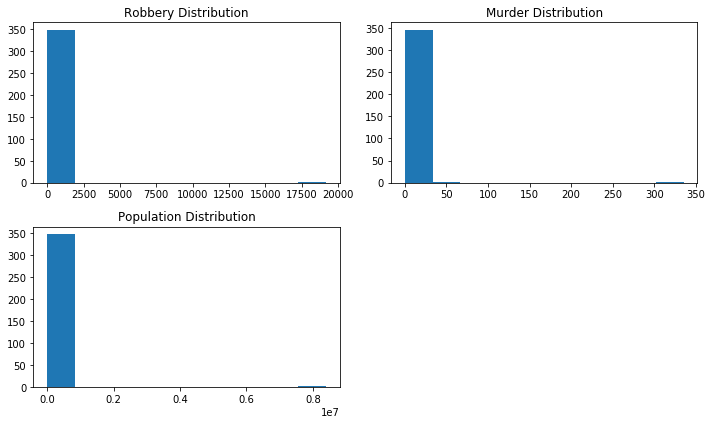

In [3]:
# population distribution
fig = plt.figure(figsize = (10,6))

fig.add_subplot(221)
plt.hist(df['Robbery'])
plt.title('Robbery Distribution')

fig.add_subplot(222)
plt.hist(df['Murder and\nnonnegligent\nmanslaughter'].dropna())
plt.title('Murder Distribution')

fig.add_subplot(223)
plt.hist(df['Population'].dropna())
plt.title('Population Distribution')
plt.tight_layout()
plt.show()


Selected variables do not look normally distributed. Seems, I'll need to normalize it using np.log()
## 2. Data Cleaning & Manipulation
Here I'll rename columns to facilitate the work, drop the last 3 rows with missing values and convert selected variables from float64 to int64

In [4]:
# rename the column
df.rename(columns = {'Murder and\nnonnegligent\nmanslaughter':'Murder', 'Property\ncrime':'Property_crime'}, inplace = True)

# remove last 3 rows 
df.drop(df.iloc[348:, :].index, inplace = True)

for col in ['Population', 'Murder', 'Robbery', 'Property_crime']:
    df[col] = df[col].astype(np.int64)
df.isnull().sum()
print(df.dtypes)

City                             object
Population                        int64
Violent\ncrime                  float64
Murder                            int64
Rape\n(revised\ndefinition)1    float64
Rape\n(legacy\ndefinition)2     float64
Robbery                           int64
Aggravated\nassault             float64
Property_crime                    int64
Burglary                        float64
Larceny-\ntheft                 float64
Motor\nvehicle\ntheft           float64
Arson3                          float64
dtype: object


## 3. Feature selection
We already know that our dependant (outcome) variable is Property Crime and independent variables are Murder, Robbery, Population.

In [5]:
# create a dataframe to hold features
features = pd.DataFrame()
features['property_crime'] = df['Property_crime']
features['murder'] = np.where(df['Murder']>=1, 1, 0)
features['robbery'] = np.where(df['Robbery']>=1, 1, 0)

# check if it works
print(df['Robbery'].groupby(features['robbery']).describe())

         count       mean          std  min  25%  50%   75%      max
robbery                                                             
0        139.0    0.00000     0.000000  0.0  0.0  0.0   0.0      0.0
1        209.0  121.38756  1329.475239  1.0  1.0  4.0  12.0  19170.0


In [6]:
# create the last feature
features['population'] = df['Population']
features['population_squared'] = np.square(features.population)
features.describe()

,property_crime,murder,robbery,population,population_squared
count,348.000000,348.000000,348.000000,3.480000e+02,3.480000e+02
mean,792.606322,0.140805,0.600575,4.003763e+04,2.035547e+11
std,7659.724746,0.348321,0.490486,4.500374e+05,3.778876e+12
min,0.000000,0.000000,0.000000,5.260000e+02,2.766760e+05
25%,40.500000,0.000000,0.000000,3.003000e+03,9.018117e+06
50%,112.500000,0.000000,1.000000,7.233500e+03,5.232568e+07
75%,341.000000,0.000000,1.000000,1.842750e+04,3.397536e+08
max,141971.000000,1.000000,1.000000,8.396126e+06,7.049493e+13


## 4. Linear Regression Model

In [7]:
# instantiate and fit our model
regr = linear_model.LinearRegression()
Y = features['property_crime']
X = features[['population','population_squared','murder','robbery']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [ 3.46570268e-02 -2.11108019e-09  1.51866535e+01 -9.62774363e+01]

Intercept: 
 -109.57533562257493

R-squared:
0.9961247104988709


R-squared is close to 1 meaning that the sum of residuals are close to 0. However, this also means that the model overfitted. The reason can be outliers. 

### 4.1 Outliers
As features are selected, before fitting the model I want to check for outliers in the variables.

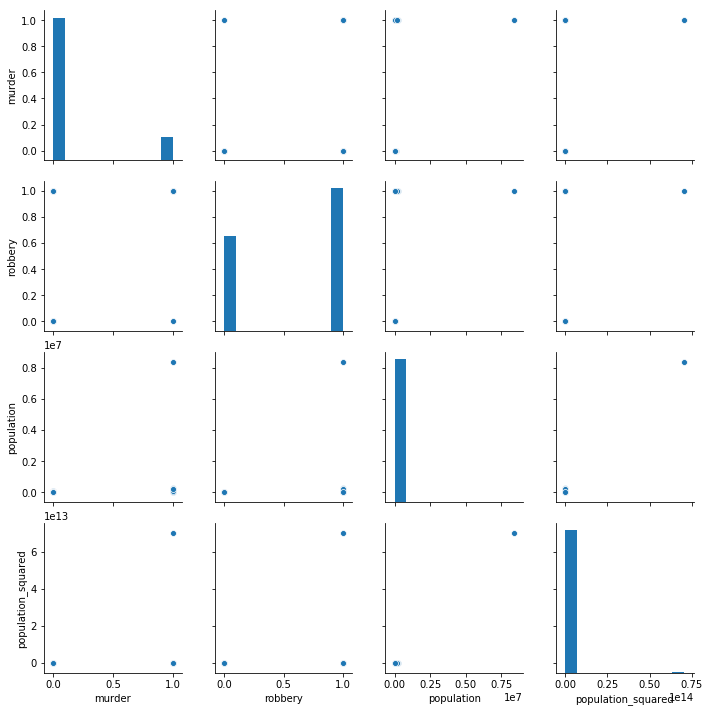

In [8]:
# pairplot the features to see the outliers
_ = sns.pairplot(features.loc[:, 'murder':])

In [9]:
# z-score method to remove outliers
no_outliers = features.copy()
z = np.abs(stats.zscore(no_outliers))
threshold = 3
features = features[(z < threshold).all(axis=1)]
print(features.shape)
features.describe()

(347, 5)


,property_crime,murder,robbery,population,population_squared
count,347.000000,347.000000,347.000000,347.000000,3.470000e+02
mean,385.752161,0.138329,0.599424,15956.685879,9.858407e+08
std,1034.369072,0.345743,0.490723,27080.218837,5.067232e+09
min,0.000000,0.000000,0.000000,526.000000,2.766760e+05
25%,40.000000,0.000000,0.000000,2997.000000,8.982153e+06
50%,112.000000,0.000000,1.000000,7187.000000,5.165297e+07
75%,340.500000,0.000000,1.000000,18160.500000,3.298042e+08
max,12491.000000,1.000000,1.000000,258789.000000,6.697175e+10


## 4.2 Normality & Linear Relationship

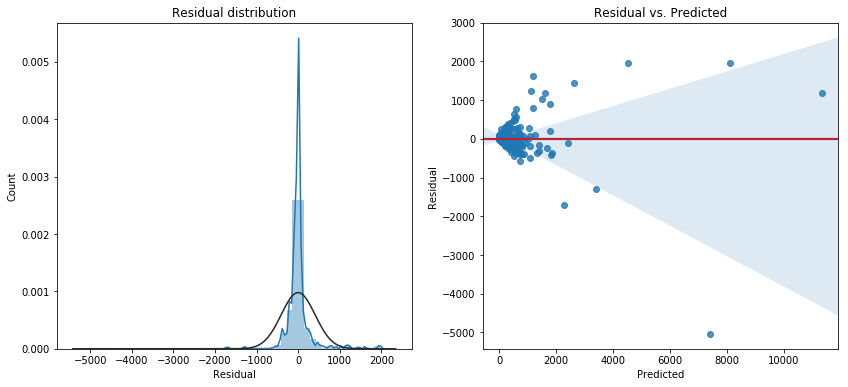

In [10]:
regr = linear_model.LinearRegression()
Y = features['property_crime']
X = features[['population','population_squared','murder','robbery']]
regr.fit(X, Y)

# extract predicted values
predicted = regr.predict(X).ravel()
actual = features['property_crime']

# Calculate the error, also called the residual.
residual = actual - predicted

# lot residual distribution
plt.figure(figsize = (14, 6))
plt.subplot(121)
_ = sns.distplot(residual, fit = norm)
_.set(title = 'Residual distribution', xlabel = 'Residual', ylabel = 'Count')

# plot residual vs. predicted scatter plot
plt.subplot(122)
_ = sns.regplot(predicted, residual)
_.axhline(y=0, color = 'r')
_.set(title = 'Residual vs. Predicted', xlabel = 'Predicted', ylabel = 'Residual')

plt.show()

Residual distribution looks normal and the relationship between residual and predicted outcome is linear. Two assumptions of multivariable linear regression are satisfied.

## 4.2 Homoscedasticity &  Low Multicollinearity

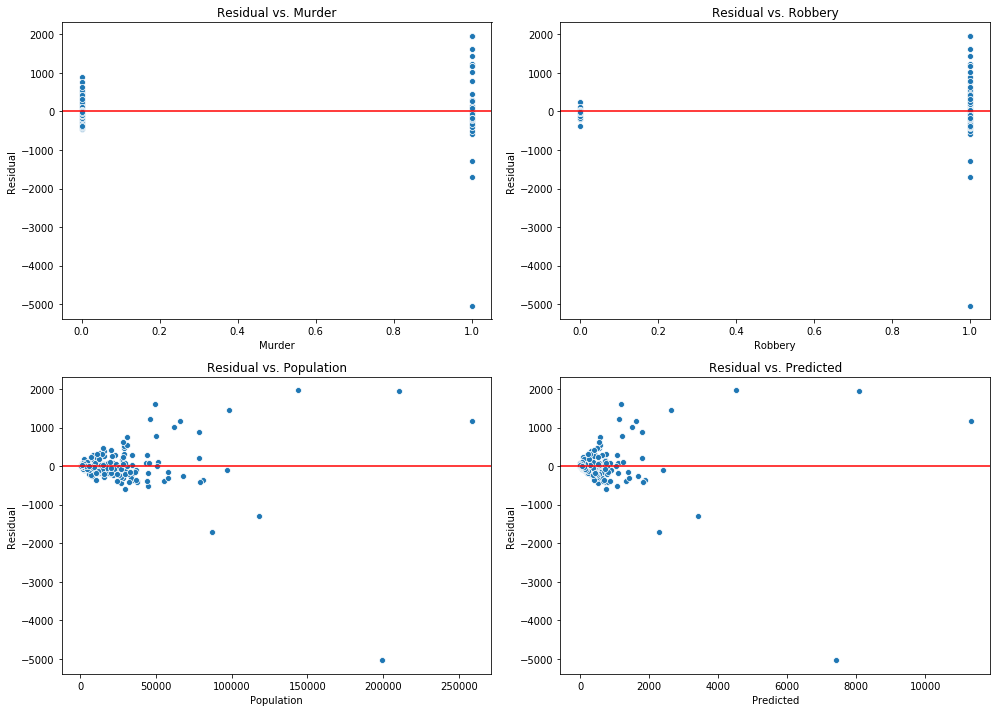

In [11]:

# plot Residual vs. Murder
plt.figure(figsize = (14,10))
plt.subplot(221)
_ = sns.scatterplot(features.murder, residual)
_.axhline(y=0, color = 'r')
_.set(title = 'Residual vs. Murder', xlabel = 'Murder', ylabel = 'Residual')

# plot Residual vs. Robbery
plt.subplot(222)
_ = sns.scatterplot(features.robbery, residual)
_.axhline(y=0, color = 'r')
_.set(title = 'Residual vs. Robbery', xlabel = 'Robbery', ylabel = 'Residual')

# plot Residual vs. Population
plt.subplot(223)
_ = sns.scatterplot(features.population, residual)
_.axhline(y=0, color = 'r')
_.set(title = 'Residual vs. Population', xlabel = 'Population', ylabel = 'Residual')

# plot Residual vs. Predicted
plt.subplot(224)
_ = sns.scatterplot(predicted, residual)
_.axhline(y=0, color = 'r')
_.set(title = 'Residual vs. Predicted', xlabel = 'Predicted', ylabel = 'Residual')

# Newspaper distribution
plt.tight_layout()

plt.show()

In [12]:
correlation_matrix = X.corr()
print(correlation_matrix)

                    population  population_squared    murder   robbery
population            1.000000            0.888582  0.502713  0.344347
population_squared    0.888582            1.000000  0.344873  0.152289
murder                0.502713            0.344873  1.000000  0.310503
robbery               0.344347            0.152289  0.310503  1.000000


In [13]:
# inspect the results
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [1.29510871e-02 1.14920528e-07 1.95038666e+02 9.28205845e+01]

Intercept: 
 -16.815866321663805

R-squared:
0.8444937611173492
